# Phase 1: Exploratory Data Analysis (EDA) - News Classification
**Project:** Document Classification System  
**Goal:** Understand the distribution, length, and characteristics of the AG News dataset.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

In [14]:
# Set visual style
sns.set_theme(style="whitegrid")
%matplotlib inline

# 1. Load the Dataset
We are using the `datasets` library from Hugging Face for efficient data streaming and loading.

In [15]:
# Load AG News dataset
dataset = load_dataset("ag_news")

In [16]:
# Convert to Pandas DataFrames
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

In [17]:
# Map numeric labels to descriptive names
# AG News labels: 0-World, 1-Sports, 2-Business, 3-Sci/Tech
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
df_train['label_name'] = df_train['label'].map(label_map)

In [18]:
print(f"Training set size: {len(df_train)}")
print(f"Testing set size: {len(df_test)}")
df_train.head()

Training set size: 120000
Testing set size: 7600


,text,label,label_name
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


## 2. Class Distribution
A balanced dataset ensures the model doesn't develop a bias toward a specific category.

/tmp/ipykernel_27218/1959834767.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_train, x='label_name', palette='viridis')


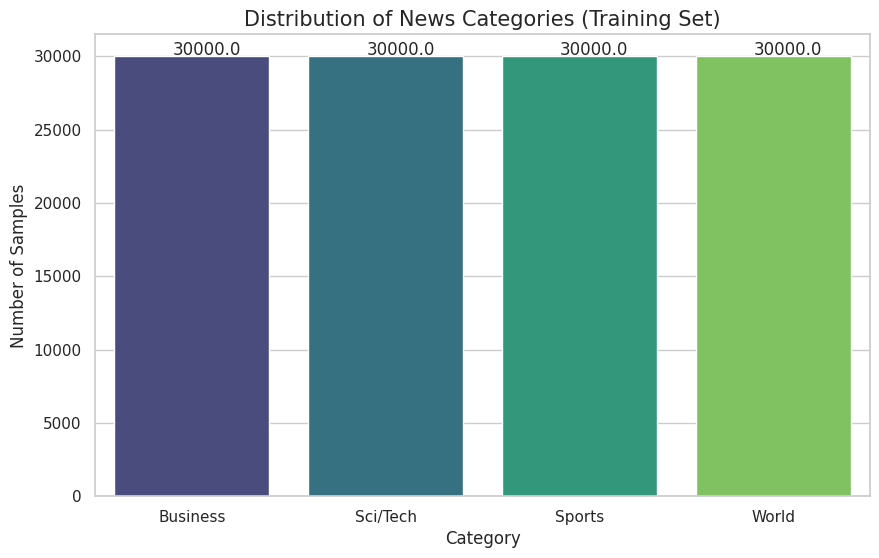

In [19]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_train, x='label_name', palette='viridis')

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 100))

plt.title('Distribution of News Categories (Training Set)', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.show()

## 3. Text Length Analysis
Understanding the number of words and characters helps in choosing hyperparameters for vectorization and deep learning padding.

In [20]:
# Calculate word count and character count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))

In [21]:
# Display statistical summary
print("Text Length Statistics:")
print(df_train[['word_count', 'char_count']].describe())

Text Length Statistics:
          word_count     char_count
count  120000.000000  120000.000000
mean       37.847450     236.477525
std        10.085245      66.509741
min         8.000000     100.000000
25%        32.000000     196.000000
50%        37.000000     232.000000
75%        43.000000     266.000000
max       177.000000    1012.000000


## 4. Distribution Visualizations
# Let's see how the word counts are distributed across the entire dataset.

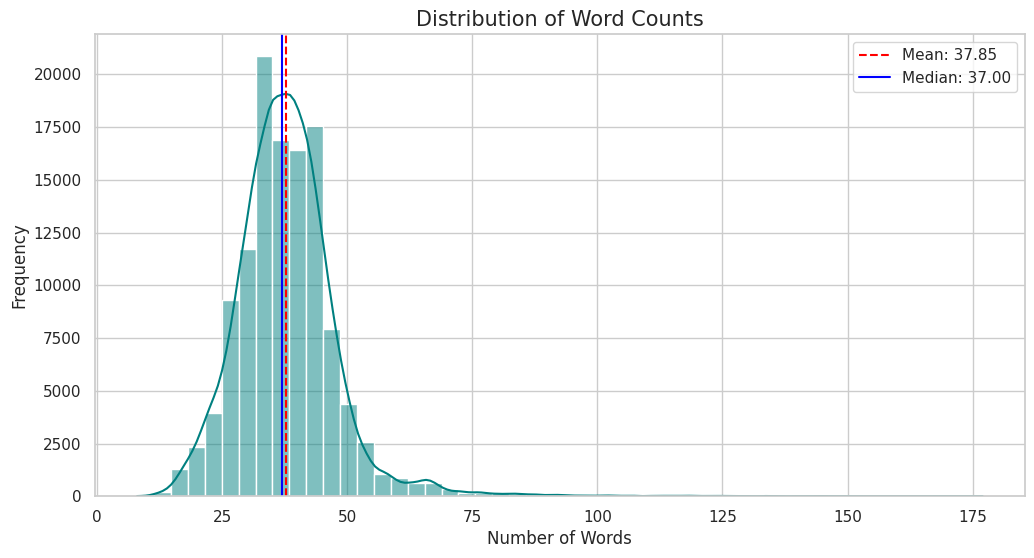

In [22]:
plt.figure(figsize=(12, 6))

# Histogram with KDE
sns.histplot(df_train['word_count'], bins=50, kde=True, color='teal')

plt.axvline(df_train['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df_train["word_count"].mean():.2f}')
plt.axvline(df_train['word_count'].median(), color='blue', linestyle='-', label=f'Median: {df_train["word_count"].median():.2f}')

plt.title('Distribution of Word Counts', fontsize=15)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

## 5. Category-wise Length Analysis
Does a specific category (like 'Sci/Tech') tend to have longer descriptions?

/tmp/ipykernel_27218/4052401339.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x='label_name', y='word_count', palette='Set2')


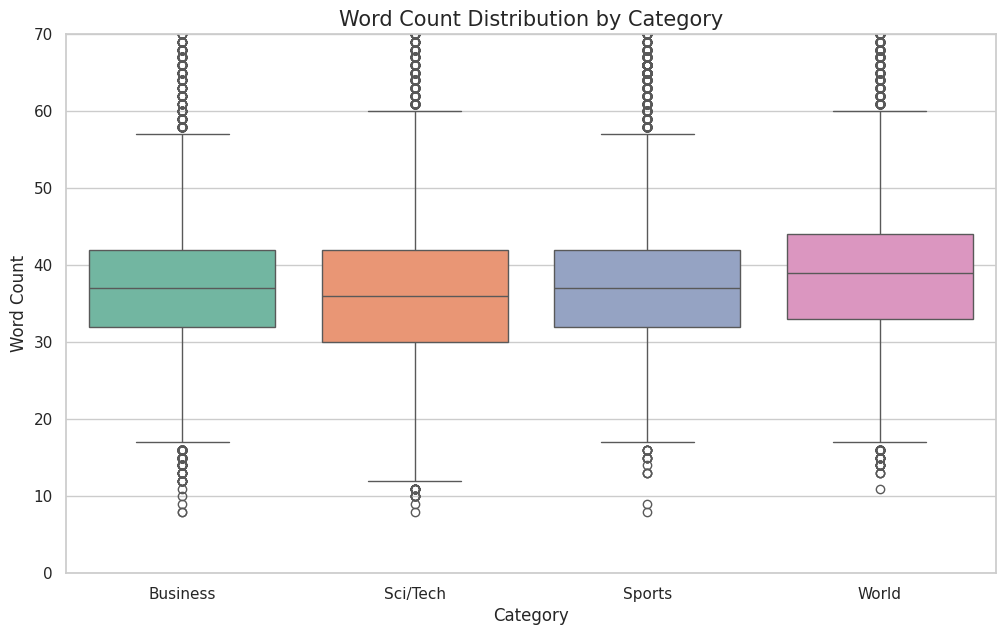

In [23]:
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_train, x='label_name', y='word_count', palette='Set2')

plt.title('Word Count Distribution by Category', fontsize=15)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
# Limiting y-axis to focus on the bulk of data (removing outliers for visualization)
plt.ylim(0, df_train['word_count'].quantile(0.99)) 
plt.show()

# 6 Data Quality Issues

In [26]:
# Search for the first 5 rows containing common HTML entities or special snippets
dirty_rows = df_train[df_train['text'].str.contains('&|#|/', regex=True)].head(5)

# Use pd.set_option to see the FULL text without it being cut off
pd.set_option('display.max_colwidth', None)
print(dirty_rows['text'])

5                                                                                                                                                                                    Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday\but stayed near lows for the year as oil prices surged past  #36;46\a barrel, offsetting a positive outlook from computer maker\Dell Inc. (DELL.O)
6                                                                                                                                                                                                            Money Funds Fell in Latest Week (AP) AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.
8     Safety Net (Forbes.com) Forbes.com - After earning a PH.D. in Sociology, Danny Bazil Riley started to work as the general manager at a commercial real e

### Data Quality Findings

| Artifact | Example from Data | Technical Explanation |
| :--- | :--- | :--- |
| **Numeric Entities** | `#36;`, `#151;` | HTML character references for symbols like `$` and `—`. |
| **Source Metadata** | `(Reuters)`, `AP -` | Repetitive news agency attributions that don't help classify the actual topic. |
| **Escaped Chars** | `\but`, `\a barrel` | Backslashes likely resulting from improper string escaping during data collection. |
| **Web Entities** | `&lt;`, `&quot;` | Standard HTML entities for `<` and `"`. |

## 6. EDA Findings & Summary

1. **Balance:** The dataset is perfectly balanced (30k samples per class). No resampling techniques are required.
2. **Length:** Most news descriptions are between **25 and 50 words**. This suggests we can set a `max_length` of ~60-70 for our Deep Learning models later.
3. **Data Quality:** Previewing the text shows some HTML entities like `&lt;` or `&quot;` and some escaped characters that will need cleaning in the Preprocessing phase.
4. **Overlap:** The boxplot shows word count distributions are very similar across categories, meaning length is not a strong feature for classification; we must rely on **semantic content**.